In [18]:
img_height, img_width = 256, 256
batch_size = 1
sar_dir = r'C:\Users\kanad\Downloads\Sentinel Data\Sentinel Data\s1'
optical_dir = r'C:\Users\kanad\Downloads\Sentinel Data\Sentinel Data\s2'

In [19]:
import tensorflow as tf
from tensorflow.keras import layers
import os
import glob
import matplotlib.pyplot as plt
import pywt
import numpy as np
import time

In [20]:
# Wavelet Denoising Function
def wavelet_denoise(image, wavelet='haar', level=2, threshold=30):
    """
    Apply wavelet denoising to a single-channel image.

    Parameters:
    - image: 3D TensorFlow tensor (height, width, channels)
    - wavelet: Wavelet type
    - level: Decomposition level
    - threshold: Threshold value for detail coefficients

    Returns:
    - denoised_image: 3D NumPy array after denoising
    """
    image = image.numpy().squeeze()  # Convert to 2D NumPy array
    coeffs = pywt.wavedec2(image, wavelet, level=level)
    coeffs_thresh = [coeffs[0]]  # LL remains unchanged
    for detail_level in coeffs[1:]:
        coeffs_thresh.append(tuple(pywt.threshold(c, threshold, mode='soft') for c in detail_level))
    denoised_image = pywt.waverec2(coeffs_thresh, wavelet)
    denoised_image = np.clip(denoised_image, -1, 1)  # Ensure values are within [-1, 1]
    denoised_image = denoised_image.astype(np.float32)
    denoised_image = denoised_image[:, :, np.newaxis]  # Add channel dimension
    return denoised_image

In [21]:
# Updated load_image Function
def load_image(image_file, denoise=False):
    """
    Load and preprocess an image.

    Parameters:
    - image_file: Path to the image file
    - denoise: Whether to apply wavelet denoising (True for SAR images)

    Returns:
    - image: Preprocessed image tensor
    """
    image = tf.io.read_file(image_file)
    if denoise:
        channels = 1  # SAR images are grayscale
    else:
        channels = 3  # Optical images are RGB
    image = tf.image.decode_png(image, channels=channels)
    image = tf.image.resize(image, [img_height, img_width])
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    
    if denoise:
        # Apply wavelet denoising using tf.py_function
        image = tf.py_function(
            func=wavelet_denoise,
            inp=[image],
            Tout=tf.float32
        )
        image.set_shape([img_height, img_width, channels])  # Set shape manually
    
    return image

# Updated preprocess_image Function
def preprocess_image(sar_file, optical_file):
    """
    Preprocess SAR and Optical images.

    Parameters:
    - sar_file: Path to the SAR image file (grayscale)
    - optical_file: Path to the Optical image file (RGB)

    Returns:
    - sar_image: Preprocessed and denoised SAR image tensor
    - optical_image: Preprocessed Optical image tensor
    """
    sar_image = load_image(sar_file, denoise=True)
    optical_image = load_image(optical_file, denoise=False)
    return sar_image, optical_image


# Updated load_dataset Function
def load_dataset(sar_dir, optical_dir):
    sar_files = sorted(glob.glob(os.path.join(sar_dir, '*.png')))
    optical_files = sorted(glob.glob(os.path.join(optical_dir, '*.png')))
    
    # Ensure that the number of SAR and Optical images match
    assert len(sar_files) == len(optical_files), "Mismatch between SAR and Optical image counts."
    
    dataset = tf.data.Dataset.from_tensor_slices((sar_files, optical_files))
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [22]:
# Define the Generator Model
def build_generator():
    inputs = layers.Input(shape=[img_height, img_width, 1])  # Single-channel input (SAR)

    # Encoder (downsampling)
    down1 = layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
    down1 = layers.LeakyReLU()(down1)

    down2 = layers.Conv2D(128, 4, strides=2, padding='same')(down1)
    down2 = layers.BatchNormalization()(down2)
    down2 = layers.LeakyReLU()(down2)

    down3 = layers.Conv2D(256, 4, strides=2, padding='same')(down2)
    down3 = layers.BatchNormalization()(down3)
    down3 = layers.LeakyReLU()(down3)

    # Bottleneck
    bottleneck = layers.Conv2D(512, 4, strides=2, padding='same')(down3)
    bottleneck = layers.ReLU()(bottleneck)

    # Decoder (upsampling)
    up1 = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(bottleneck)
    up1 = layers.BatchNormalization()(up1)
    up1 = layers.ReLU()(up1)

    up2 = layers.Conv2DTranspose(128, 4, strides=2, padding='same')(up1)
    up2 = layers.BatchNormalization()(up2)
    up2 = layers.ReLU()(up2)

    up3 = layers.Conv2DTranspose(64, 4, strides=2, padding='same')(up2)
    up3 = layers.BatchNormalization()(up3)
    up3 = layers.ReLU()(up3)

    # Output layer
    outputs = layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(up3)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [23]:

# Define the Discriminator Model
def build_discriminator():
    inp = layers.Input(shape=[img_height, img_width, 1], name='input_image')  # SAR input
    tar = layers.Input(shape=[img_height, img_width, 3], name='target_image')  # Optical target

    combined = layers.concatenate([inp, tar])  # Concatenate along channels

    down1 = layers.Conv2D(64, 4, strides=2, padding='same')(combined)
    down1 = layers.LeakyReLU()(down1)

    down2 = layers.Conv2D(128, 4, strides=2, padding='same')(down1)
    down2 = layers.BatchNormalization()(down2)
    down2 = layers.LeakyReLU()(down2)

    down3 = layers.Conv2D(256, 4, strides=2, padding='same')(down2)
    down3 = layers.BatchNormalization()(down3)
    down3 = layers.LeakyReLU()(down3)

    down4 = layers.Conv2D(512, 4, strides=2, padding='same')(down3)
    down4 = layers.BatchNormalization()(down4)
    down4 = layers.LeakyReLU()(down4)

    outputs = layers.Conv2D(1, 4, strides=1, padding='same')(down4)

    return tf.keras.Model(inputs=[inp, tar], outputs=outputs)

In [24]:
# Define Loss Functions
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    return gan_loss + (100 * l1_loss)

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(disc_generated_output), disc_generated_output)
    return real_loss + generated_loss

# Define Optimizers
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [25]:
# Define the Training Step
@tf.function
def train_step(input_image, target, generator, discriminator):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    return gen_loss, disc_loss

In [26]:
# Define the Training Loop
def train(dataset, epochs, generator, discriminator):
    for epoch in range(epochs):
        start = time.time()
        total_gen_loss = 0
        total_disc_loss = 0
        num_batches = 0

        for input_image, target in dataset:
            gen_loss, disc_loss = train_step(input_image, target, generator, discriminator)
            total_gen_loss += gen_loss
            total_disc_loss += disc_loss
            num_batches += 1

        # Compute average losses
        avg_gen_loss = total_gen_loss / num_batches
        avg_disc_loss = total_disc_loss / num_batches

        print(f'Epoch {epoch+1}, Generator Loss: {avg_gen_loss.numpy()}, Discriminator Loss: {avg_disc_loss.numpy()}')
        print(f'Time taken for epoch {epoch+1} is {time.time()-start:.4f} sec\n')


In [27]:
# Define the Image Generation Function
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=False)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Actual Image', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Rescale images from [-1,1] to [0,1] for display
        img = (display_list[i] + 1) / 2
        plt.imshow(img)
        plt.axis('off')
    plt.show()


In [28]:
test_dataset = load_dataset(sar_dir, optical_dir)
generator = build_generator()
discriminator = build_discriminator()

# Train the model (replace `epochs` with desired number)
train(test_dataset, epochs=10, generator=generator, discriminator=discriminator)

Epoch 1, Generator Loss: 34.161956787109375, Discriminator Loss: 0.5926429629325867
Time taken for epoch 1 is 395.4697 sec

Epoch 2, Generator Loss: 34.062347412109375, Discriminator Loss: 0.7258603572845459
Time taken for epoch 2 is 365.4750 sec

Epoch 3, Generator Loss: 32.439510345458984, Discriminator Loss: 0.8085880279541016
Time taken for epoch 3 is 339.4609 sec

Epoch 4, Generator Loss: 30.52850341796875, Discriminator Loss: 0.8276841640472412
Time taken for epoch 4 is 344.1578 sec

Epoch 5, Generator Loss: 28.667186737060547, Discriminator Loss: 0.8579674363136292
Time taken for epoch 5 is 345.4007 sec

Epoch 6, Generator Loss: 27.067712783813477, Discriminator Loss: 0.8847805261611938
Time taken for epoch 6 is 346.7886 sec

Epoch 7, Generator Loss: 25.96576499938965, Discriminator Loss: 0.8828330636024475
Time taken for epoch 7 is 345.2520 sec

Epoch 8, Generator Loss: 25.702245712280273, Discriminator Loss: 0.8117056488990784
Time taken for epoch 8 is 345.8704 sec

Epoch 9, G

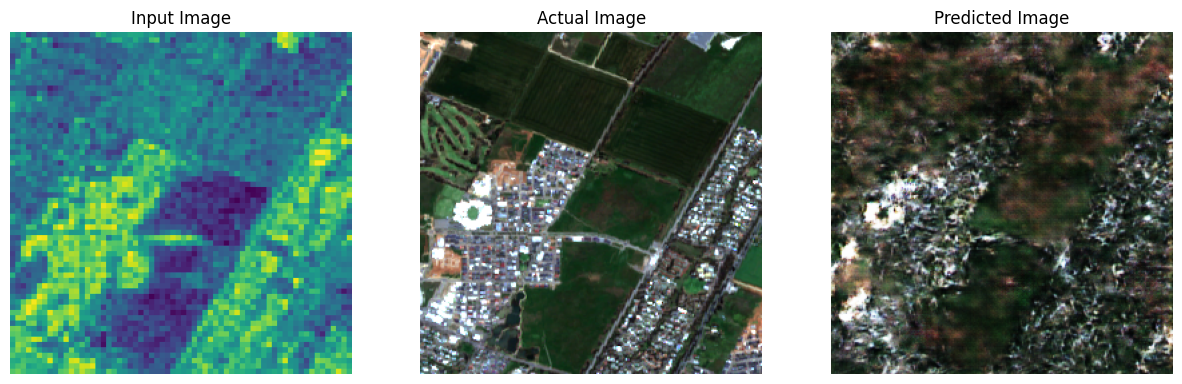

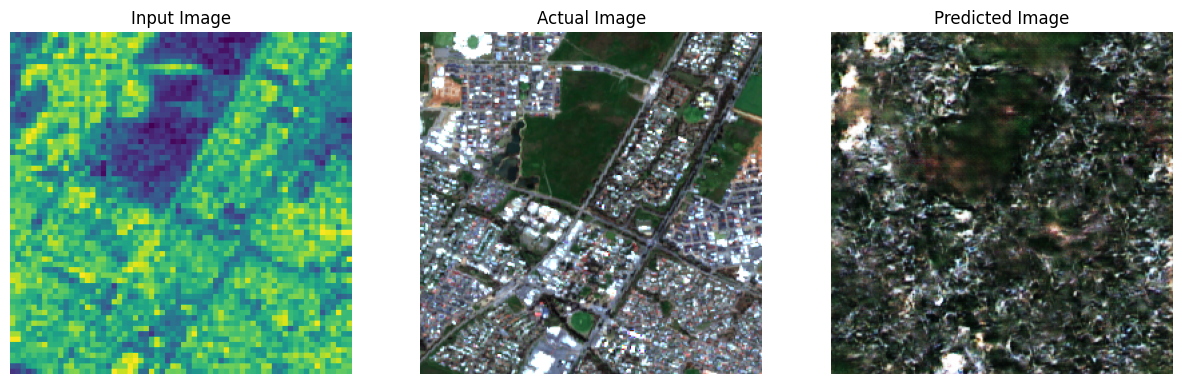

In [29]:
for example_input, example_target in test_dataset.take(2):
    generate_images(generator, example_input, example_target)